In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from model.model import GTN
from utils.utils import f1_score, true_positive_rate, false_positive_rate
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
epochs = 50
node_dim = 64
num_channels = 2
lr = 0.005
weight_decay = 0.001
num_layers = 2
norm = True
adaptive_lr = True

In [3]:
dataset = "ACM"

In [4]:
with open('data/'+dataset+'/node_features.pkl', 'rb') as f:
    node_features = pickle.load(f)
with open('data/'+dataset+'/edges.pkl', 'rb') as f:
    edges = pickle.load(f)
with open('data/'+dataset+'/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

/tmp/ipykernel_1559190/2598945757.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  edges = pickle.load(f)
/tmp/ipykernel_1559190/2598945757.py:4: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  edges = pickle.load(f)


In [5]:
node_features.shape


(8994, 1902)

In [6]:
edges

[<8994x8994 sparse matrix of type '<class 'numpy.int32'>'
 	with 9936 stored elements in Compressed Sparse Row format>,
 <8994x8994 sparse matrix of type '<class 'numpy.int32'>'
 	with 9936 stored elements in Compressed Sparse Column format>,
 <8994x8994 sparse matrix of type '<class 'numpy.int32'>'
 	with 3025 stored elements in Compressed Sparse Row format>,
 <8994x8994 sparse matrix of type '<class 'numpy.int32'>'
 	with 3025 stored elements in Compressed Sparse Column format>]

In [7]:
labels

[array([[ 826,    0],
        [1823,    0],
        [1382,    0],
        ...,
        [2480,    2],
        [2596,    2],
        [2958,    2]]),
 array([[1770,    0],
        [ 888,    0],
        [1737,    0],
        [1793,    0],
        [2389,    0],
        [1454,    0],
        [1600,    0],
        [2374,    0],
        [1067,    0],
        [1125,    0],
        [ 963,    0],
        [1551,    0],
        [ 991,    0],
        [1358,    0],
        [1101,    0],
        [1913,    0],
        [1677,    0],
        [1540,    0],
        [1909,    0],
        [1038,    0],
        [1042,    0],
        [1452,    0],
        [1560,    0],
        [ 979,    0],
        [2361,    0],
        [1837,    0],
        [1568,    0],
        [1941,    0],
        [1815,    0],
        [1258,    0],
        [1751,    0],
        [1655,    0],
        [1859,    0],
        [1569,    0],
        [1756,    0],
        [2352,    0],
        [1583,    0],
        [1260,    0],
        [ 894,   

In [8]:
num_nodes = edges[0].shape[0]

for i,edge in enumerate(edges):
    if i ==0:
        A = torch.from_numpy(edge.todense()).type(torch.FloatTensor).unsqueeze(-1)
    else:
        A = torch.cat([A,torch.from_numpy(edge.todense()).type(torch.FloatTensor).unsqueeze(-1)], dim=-1)
A = torch.cat([A,torch.eye(num_nodes).type(torch.FloatTensor).unsqueeze(-1)], dim=-1)

In [9]:
node_features = torch.from_numpy(node_features).type(torch.FloatTensor)
train_node = torch.from_numpy(np.array(labels[0])[:,0]).type(torch.LongTensor)
train_target = torch.from_numpy(np.array(labels[0])[:,1]).type(torch.LongTensor)
valid_node = torch.from_numpy(np.array(labels[1])[:,0]).type(torch.LongTensor)
valid_target = torch.from_numpy(np.array(labels[1])[:,1]).type(torch.LongTensor)
test_node = torch.from_numpy(np.array(labels[2])[:,0]).type(torch.LongTensor)
test_target = torch.from_numpy(np.array(labels[2])[:,1]).type(torch.LongTensor)


In [10]:
num_classes = torch.max(train_target).item()+1
final_f1 = 0

model = GTN(num_edge=A.shape[-1],
            num_channels=num_channels,
            w_in=node_features.shape[1],
            w_out=node_dim,
            num_class=num_classes,
            num_layers=num_layers,
            norm=norm)
if adaptive_lr == 'false':
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
else:
    optimizer = torch.optim.Adam([{'params': model.weight},
                                  {'params': model.linear1.parameters()},
                                  {'params': model.linear2.parameters()},
                                  {"params": model.layers.parameters(), "lr": 0.5}
                                  ], lr=0.005, weight_decay=0.001)
loss = nn.CrossEntropyLoss()

In [11]:
# Train & Valid & Test
best_val_loss = 10000
best_test_loss = 10000
best_train_loss = 10000
best_train_f1 = 0
best_val_f1 = 0
best_test_f1 = 0
valloss =[]
testloss =[]
trainloss =[]
trainf1=[]
testf1=[]
valf1=[]

In [12]:
for i in range(epochs):
    for param_group in optimizer.param_groups:
        if param_group['lr'] > 0.005:
             param_group['lr'] = param_group['lr'] * 0.9
    print('Epoch:  ',i+1)
    model.zero_grad()
    model.train()
    loss,y_train,Ws = model(A, node_features, train_node, train_target)
    train_f1 = torch.mean(f1_score(torch.argmax(y_train.detach(),dim=1), train_target, num_classes=num_classes)).cpu().numpy()
    trainloss.append(loss.detach().cpu().numpy())
    trainf1.append(train_f1)
    print('Train - Loss: {}, Macro_F1: {}'.format(loss.detach().cpu().numpy(), train_f1))
    loss.backward()
    optimizer.step()
    model.eval()
    # Valid
    with torch.no_grad():
        val_loss, y_valid,_ = model.forward(A, node_features, valid_node, valid_target)
        val_f1 = torch.mean(f1_score(torch.argmax(y_valid,dim=1), valid_target, num_classes=num_classes)).cpu().numpy()
        valloss.append(val_loss.detach().cpu().numpy())
        valf1.append(val_f1)
        print('Valid - Loss: {}, Macro_F1: {}'.format(val_loss.detach().cpu().numpy(), val_f1))
        test_loss, y_test,W = model.forward(A, node_features, test_node, test_target)
        test_f1 = torch.mean(f1_score(torch.argmax(y_test,dim=1), test_target, num_classes=num_classes)).cpu().numpy()
        testloss.append(test_loss.detach().cpu().numpy())
        testf1.append(test_f1)
        print('Test - Loss: {}, Macro_F1: {}\n'.format(test_loss.detach().cpu().numpy(), test_f1))
        if val_f1 > best_val_f1:
            best_val_loss = val_loss.detach().cpu().numpy()
            best_test_loss = test_loss.detach().cpu().numpy()
            best_train_loss = loss.detach().cpu().numpy()
            best_train_f1 = train_f1
            best_val_f1 = val_f1
            best_test_f1 = test_f1

print('---------------Best Results--------------------')
print('Train - Loss: {}, Macro_F1: {}'.format(best_train_loss, best_train_f1))
print('Valid - Loss: {}, Macro_F1: {}'.format(best_val_loss, best_val_f1))
print('Test - Loss: {}, Macro_F1: {}'.format(best_test_loss, best_test_f1))
final_f1 += best_test_f1

Epoch:   1
Train - Loss: 1.0957717895507812, Macro_F1: 0.2428092509508133
Valid - Loss: 1.0411616563796997, Macro_F1: 0.522111177444458
Test - Loss: 1.0422215461730957, Macro_F1: 0.5100898146629333

Epoch:   2
Train - Loss: 1.0301159620285034, Macro_F1: 0.5896616578102112
Valid - Loss: 0.9793007373809814, Macro_F1: 0.3085668683052063
Test - Loss: 0.9753368496894836, Macro_F1: 0.2986818552017212

Epoch:   3
Train - Loss: 0.9652075171470642, Macro_F1: 0.30844447016716003
Valid - Loss: 0.8978615403175354, Macro_F1: 0.657934844493866
Test - Loss: 0.9115462899208069, Macro_F1: 0.620150089263916

Epoch:   4
Train - Loss: 0.859910249710083, Macro_F1: 0.7339245676994324
Valid - Loss: 0.7435715794563293, Macro_F1: 0.7615466117858887
Test - Loss: 0.7546448111534119, Macro_F1: 0.7747101783752441

Epoch:   5
Train - Loss: 0.6989166736602783, Macro_F1: 0.8724308609962463
Valid - Loss: 0.6013633012771606, Macro_F1: 0.8422105312347412
Test - Loss: 0.6086642146110535, Macro_F1: 0.8329558968544006

Epo

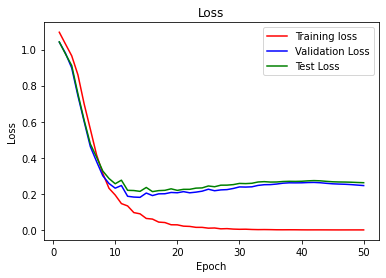

In [13]:
x = np.linspace(1,epochs)
plt.plot(x,trainloss,'r-',label="Training loss")
plt.plot(x,valloss,'b-',label="Validation Loss")
plt.plot(x,testloss,'g-',label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

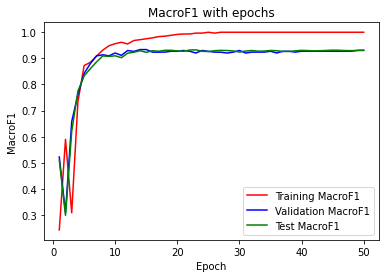

In [14]:
x = np.linspace(1,epochs)
plt.plot(x,trainf1,'r-',label="Training MacroF1")
plt.plot(x,valf1,'b-',label="Validation MacroF1")
plt.plot(x,testf1,'g-',label="Test MacroF1")
plt.title("MacroF1 with epochs")
plt.xlabel("Epoch")
plt.ylabel("MacroF1")
plt.legend()
plt.show()